In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

In [2]:
# Load data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import files
!pip  install -q kaggle

In [4]:
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d robinreni/signature-verification-dataset


In [ ]:
!unzip signature-verification-dataset.zip

In [43]:
# Update file paths
train_dir = "sign_data/train/"
test_dir = "sign_data/test/"

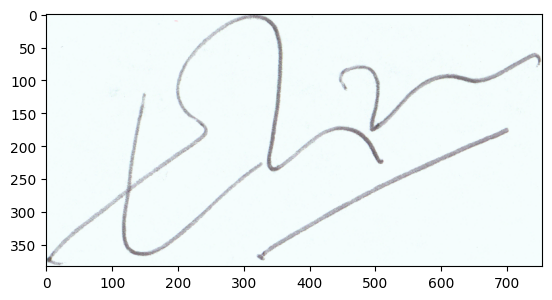

In [44]:
# Đọc chữ ký thật và chữ ký giả mạo
img = plt.imread('sign_data/train/001/001_02.PNG')
plt.imshow(img)

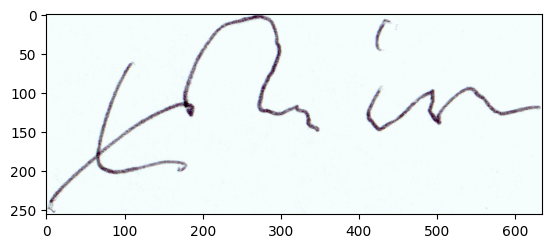

In [45]:
img = plt.imread('sign_data/train/001_forg/0119001_02.png')
plt.imshow(img)

In [46]:
# Định nghĩa kích thước ảnh
size = 100

# Load training data
train_data = []
train_labels = []

# lấy danh sách các thư mục con
for per in os.listdir(train_dir):
  # tìm tất cả các tệp ảnh trong mỗi thư mục con. *.* đại diện cho tất cả các tệp có phần mở rộng
    for data in glob.glob(train_dir + per + '/*.*'):
      # đọc và chuyển đổi thành ảnh xám & thay đổi kích thước ảnh thành  100x100.
        img = cv2.imread(data, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (size, size))
        train_data.append([img])
        if per[-1] == 'g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))
# chuẩn hóa giá trị ảnh về khoảng [0, 1]
train_data = np.array(train_data) / 255.0
train_labels = np.array(train_labels)
train_labels = to_categorical(train_labels)


In [47]:
train_labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [48]:
# Load testing data
test_data = []
test_labels = []
for per in os.listdir(test_dir):
    for data in glob.glob(test_dir + per + '/*.*'):
        img = cv2.imread(data, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (size, size))
        test_data.append([img])
        if per[-1] == 'g':
            test_labels.append(1)
        else:
            test_labels.append(0)

test_data = np.array(test_data) / 255.0
test_labels = np.array(test_labels)


In [49]:
print(len(test_data))

500


In [50]:
# Reshape data
train_data = train_data.reshape(-1, size, size, 1)
test_data = test_data.reshape(-1, size, size, 1)
train_data.shape

(1649, 100, 100, 1)

In [51]:
# Shuffle data
train_data, train_labels = shuffle(train_data, train_labels,random_state=42)
test_data, test_labels = shuffle(test_data, test_labels, random_state=42)

In [52]:
# Define the neural network model
network = Sequential()
# Thêm lớp Convolutional đầu tiên
# 64 là số lượng bộ lọc, (3, 3) là kích thước của mỗi bộ lọc
# input_shape=(size, size, 1) chỉ kích thước của ảnh đầu vào (chiều rộng x chiều cao x số kênh màu),
network.add(Conv2D(64, (3, 3), input_shape=(size, size, 1), activation='relu'))
network.add(MaxPooling2D(3, 3))
network.add(Conv2D(32, (3, 3), activation='relu'))
network.add(MaxPooling2D(2, 2))
# Làm phẳng đầu ra để chuẩn bị cho lớp Fully Connected.
network.add(Flatten())
#Thêm lớp Fully Connected
network.add(Dense(128, activation='relu'))
#giảm overfitting bằng cách loại bỏ ngẫu nhiên một số nơ-ron trong quá trình huấn luyện.
#30% số nơ-ron sẽ bị loại bỏ ngẫu nhiên trong mỗi lượt huấn luyện.
network.add(Dropout(rate=0.3))
# Lớp đầu ra với 2 nơ-ron và activation function là softmax
network.add(Dense(2, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
network.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 7200)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [54]:
# Define early stopping callback
# Callback này sẽ dừng sớm quá trình huấn luyện nếu không có cải thiện đáng kể trong việc giảm mất mát trên tập validation
# - monitor: Đại lượng mà callback sẽ theo dõi, ở đây là 'val_loss' (hàm mất mát trên tập validation)
# - min_delta: Ngưỡng, nếu thay đổi trong 'val_loss' nhỏ hơn min_delta, sẽ được coi là không cải thiện
# - patience: Số lượng lần kiểm tra không cải thiện mà chúng ta sẽ chịu đựng trước khi dừng sớm huấn luyện
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1)

In [ ]:
# Train the model
EPOCHS = 20
BS = 64
progress = network.fit(train_data, train_labels, batch_size=BS, epochs=EPOCHS, callbacks=[earlyStopping], validation_split=0.3)

In [ ]:
# Plot training progress
acc = progress.history['accuracy']
val_acc = progress.history['val_accuracy']
loss = progress.history['loss']
val_loss = progress.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# # Make predictions on test data
# pred = network.predict(test_data)
# predict = np.argmax(pred, axis=1)

# # Calculate accuracy
# accuracy = accuracy_score(predict, test_labels)
# print("Accuracy:", accuracy)

In [58]:
# Test với dữ liệu mới
img_uploaded = files.upload()

Saving testchuky.jpg to testchuky.jpg


In [59]:
your_signature_path = "testchuky.jpg"
your_signature_img = cv2.imread(your_signature_path, cv2.IMREAD_GRAYSCALE)


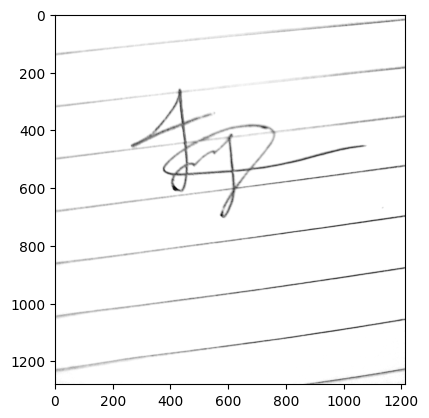

In [60]:

plt.imshow(your_signature_img,cmap='gray')

In [61]:
your_signature_img = cv2.resize(your_signature_img, (size, size))
your_signature_img = your_signature_img / 255.0  # Normalize
your_signature_img = your_signature_img.reshape(1, size, size, 1)


In [44]:
# --- Predict with your signature ---
prediction = network.predict(your_signature_img)
predicted_class = np.argmax(prediction, axis=1)

# --- Display Result ---
if predicted_class[0] == 0:
    print("This signature is likely a REAL signature.")
else:
    print("This signature is likely a FORGED signature.")

1/1 [==============================] - 0s 103ms/step
This signature is likely a REAL signature.
